# Machine Learning with Time Series

blah

In [197]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

from tsfresh import extract_features, select_features, extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute, roll_time_series, make_forecasting_frame

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

np.random.seed(23)

In [177]:
def get_data():
    df = sm.datasets.co2.load_pandas().data
    df.index = pd.to_datetime(df.index)
    df = df.resample('D').mean().interpolate('linear')
    return df

def get_scores(model,X_train,y_train,X_test,y_test):
    yhat = model.predict(X_train)
    score = r2_score(y_train,yhat)
    print('Training R-squared: %f' % round(score,3))
    
    yhat = model.predict(X_test)
    score = r2_score(y_test,yhat)
    print('Test R-squared: %f' % round(score,3))
    
    if isinstance(model,RandomForestRegressor):
        score = model.oob_score_
        print('Out of Bag Score: %f' % round(score,3))

def time_series_split(X,y,test_size=0.2):
    split_index = round(len(y)*(1-test_size))-1
    X_train = X[:split_index]
    y_train = y[:split_index]
    X_test = X[split_index:]
    y_test = y[split_index:]
    return X_train, X_test, y_train, y_test

def get_lag_features(X,feat_name,n_lags):
    for i in range(1,n_lags+1):
        X[feat_name+'_lag_'+str(i)] = X[feat_name].shift(i).fillna(method='bfill')
    X[feat_name+'_lag_0'] = X[feat_name].copy()
    X = X.drop(feat_name,axis=1)
    return X

In [178]:
df = get_data()
df.head()

,co2
1958-03-29,316.100000
1958-03-30,316.271429
1958-03-31,316.442857
1958-04-01,316.614286
1958-04-02,316.785714


In [179]:
df['x'] = df.co2.shift(1).fillna(method='bfill')
df['y'] = df.co2
df = df[['x','y']]
df.head()

,x,y
1958-03-29,316.100000,316.100000
1958-03-30,316.100000,316.271429
1958-03-31,316.271429,316.442857
1958-04-01,316.442857,316.614286
1958-04-02,316.614286,316.785714


In [185]:
X = df[['x']]
y = df.y
X_train, X_test, y_train, y_test = time_series_split(X,y,test_size=0.2)

In [186]:
model = RandomForestRegressor(n_estimators=50,min_samples_leaf=1,max_features=0.2,oob_score=True,n_jobs=-1)
model.fit(X_train,y_train)
get_scores(model,X_train,y_train,X_test,y_test)

Training R-squared: 1.000000
Test R-squared: -0.677000
Out of Bag Score: 1.000000


In [187]:
X = df[['x']].diff(periods=365).diff().fillna(method='bfill')
y = df.y.diff(periods=365).diff().fillna(method='bfill')
X_train, X_test, y_train, y_test = time_series_split(X,y,test_size=0.2)

In [188]:
model = RandomForestRegressor(n_estimators=50,min_samples_leaf=1,max_features=1.,oob_score=True,n_jobs=-1)
model.fit(X_train,y_train)
get_scores(model,X_train,y_train,X_test,y_test)

Training R-squared: 0.636000
Test R-squared: 0.693000
Out of Bag Score: 0.628000


In [189]:
X = df[['x']].diff(periods=365).diff().fillna(method='bfill')
X = get_lag_features(X,'x',20)
y = df.y.diff(periods=365).diff().fillna(method='bfill')
X_train, X_test, y_train, y_test = time_series_split(X,y,test_size=0.2)

In [190]:
model = RandomForestRegressor(n_estimators=50,min_samples_leaf=1,max_features=0.2,oob_score=True,n_jobs=-1)
model.fit(X_train,y_train)
get_scores(model,X_train,y_train,X_test,y_test)

Training R-squared: 0.969000
Test R-squared: 0.776000
Out of Bag Score: 0.776000


In [191]:
# df = df.head(1000).copy()
# df['id'] = np.ones(len(df)).astype(int)
# df['time'] = df.index
# feats = extract_features(df, column_id='id', column_sort='time', column_value='co2', n_jobs=4)
# df['y'] = df.co2.shift(1).fillna(method='bfill')
# #feats_filt = select_features(feats,df.y)
# df.head()

In [192]:
score = r2_score(y_test,np.ones(len(y_test))*np.mean(y_test))
print('Test R-squared: %f' % round(score,3))

Test R-squared: 0.000000


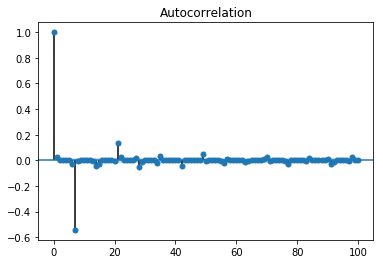

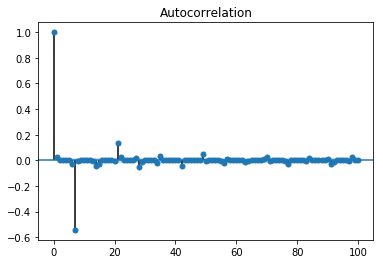

In [184]:
plot_acf(df[['y']].diff(periods=365).diff().diff().dropna(),lags=100)

In [181]:
df[['y']].diff(periods=365).diff().dropna().shape

(15616, 1)

In [195]:
df[['y']].diff(periods=365).head(370)

,y
1958-03-29,NaN
1958-03-30,NaN
1958-03-31,NaN
1958-04-01,NaN
1958-04-02,NaN
1958-04-03,NaN
1958-04-04,NaN
1958-04-05,NaN
1958-04-06,NaN
1958-04-07,NaN


In [211]:
x,y = make_forecasting_frame(df.y, kind="1", max_timeshift=20, rolling_direction=1)

In [212]:
x.head()

,time,value,id,kind
303449,1958-03-29,316.100000,1958-03-30,1
287469,1958-03-29,316.100000,1958-03-31,1
303450,1958-03-30,316.271429,1958-03-31,1
271490,1958-03-29,316.100000,1958-04-01,1
287470,1958-03-30,316.271429,1958-04-01,1


https://github.com/blue-yonder/tsfresh/blob/master/notebooks/timeseries_forecasting_google_stock.ipynb